In [1]:
%reset -f
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
# mpl.rc('title', fontsize=30)
from joblib import load
import numpy as np
import tensorflow as tf
from wgan_gp import WGAN

# try:
#     # Disable all GPUS
#     tf.config.set_visible_devices([], 'GPU')
#     visible_devices = tf.config.get_visible_devices()
#     for device in visible_devices:
#         assert device.device_type != 'GPU'
# except:
#     # Invalid device or cannot modify virtual devices once initialized.
#     pass
print(tf.config.get_visible_devices())


# scl_lab, final_act = "minmax", "tanh"
scl_lab, final_act = "standard", "linear"
# scl_lab, final_act = "robust", "linear"
mname, epoch = "wgan_211022-1156", 100

train = np.load(f"data/processed/X_{scl_lab}.npy")
sclr = load(f"data/processed/{scl_lab}_sclr")
wgan = WGAN(final_act=final_act)
wgan.gen.load_weights(f"generator_weights_beefyreg.h5")#models/{mname}/epoch{epoch}/generator_weights.h5")#
wgan.dis.load_weights(f"discriminator_weights_beefyreg.h5")#models/{mname}/epoch{epoch}/discriminator_weights.h5")#

feature_names = ['Q2', 'W', 'Gamnu', 'Xbj', 'y', 't', 'phih', 
                'electron px', 'photon px', 'proton px', 
                'electron py', 'photon py', 'proton py', 
                'electron pz', 'photon pz', 'proton pz', 
                'electron E',  'photon E',  'proton E']

print(train.shape)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
(1000000, 19)


In [2]:
true = sclr.inverse_transform(train)
n_samples = train.shape[0] #100000
random_latent_vectors = tf.random.normal(shape=(n_samples, 128))
pred = sclr.inverse_transform(wgan.gen.predict(random_latent_vectors))

chi2 =  3577135859.863732


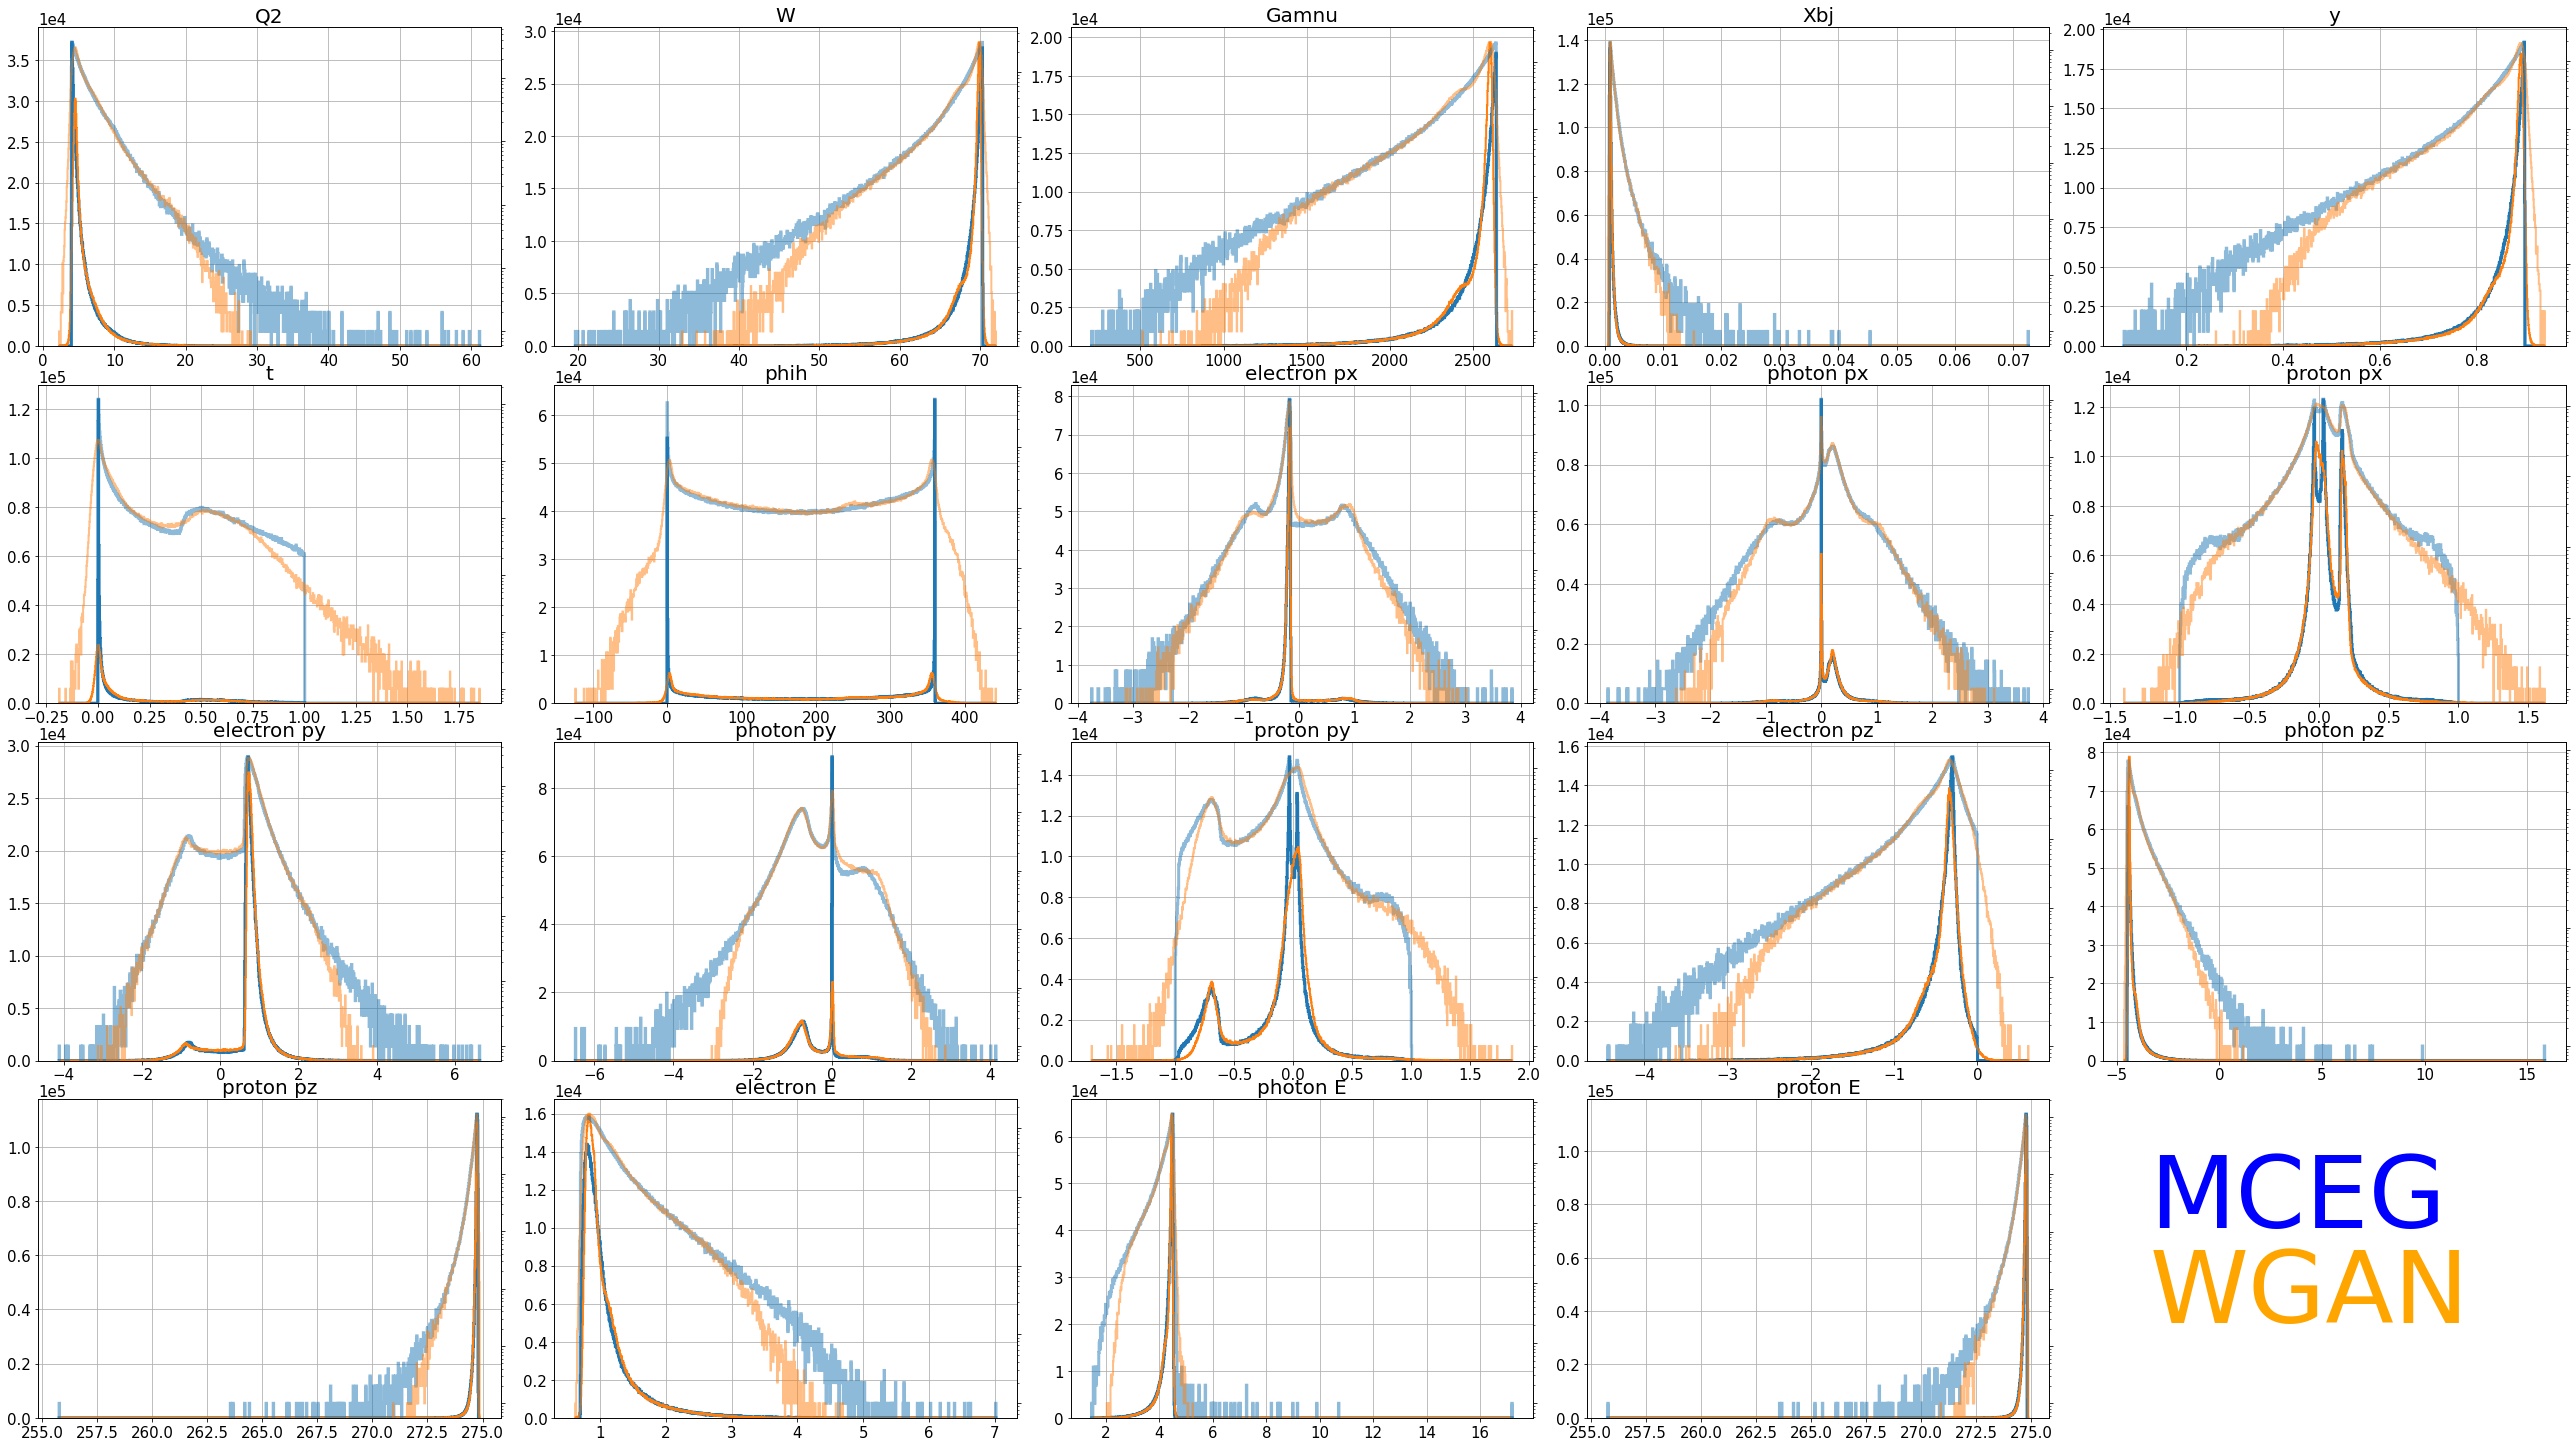

In [3]:
f, axs = plt.subplots(4,5, figsize=(36,20)); f.tight_layout()
axs = axs.flatten()
chi2=0
for i in range(pred.shape[1]):
    ax = axs[i]
    alpha = 1
    ax.grid(which='both')
    ax.set_title(feature_names[i], fontsize=20)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    for k in range(2):
        if k == 1:
            ax = ax.twinx()
            ax.set_yscale('log')
            alpha = 0.5
            ax.set_yticklabels([])
        bins = np.linspace(np.min(np.r_[true[:,i], pred[:,i]]), np.max(np.r_[true[:,i],pred[:,i]]), 1000+1)
        vr, _, _ = ax.hist(true[:,i],histtype='step',bins=bins, label="MCEG", linewidth=3, alpha=alpha)#, weights=np.ones_like(true[:,i])/len(true))#, density=True)
        vf, _, _ = ax.hist(pred[:,i],histtype='step',bins=bins, label="WGAN", linewidth=2, alpha=alpha)#, weights=np.ones_like(pred[:,i])/len(pred))#, density=True)
    chi2 += np.sum(((vr-vf)/(np.max([np.ones_like(vr),np.sqrt(vr)], axis=0)))**2)#np.sqrt(vr)
        # ax.set_xlim([-1.1,1.1])
    # ax.legend()
axs[-1].set_axis_off()
axs[-1].text(0.1, 0.6, "MCEG", fontsize=100, color='b')
axs[-1].text(0.1, 0.3, "WGAN", fontsize=100, color='orange')
# axs[-1].text(0.1, 0.1, "Epoch", fontsize=100, color='orange')

print("chi2 = ",chi2)
f.savefig(f"imgs/train_true_all_features.png", bbox_inches='tight', dpi=300)


In [4]:
def mpl_labels(ax, x, y, lab, title, fontsize=20):
    ax.set_xlabel(x, fontsize=fontsize)
    if lab == "MCEG": ax.set_ylabel(y, fontsize=fontsize)
    ax.set_title(lab+" "+title, fontsize=fontsize)
    ax.grid()

In [5]:
(0.005-0.0001)/(20-2)*(8-3)+0.0006

0.001961111111111111

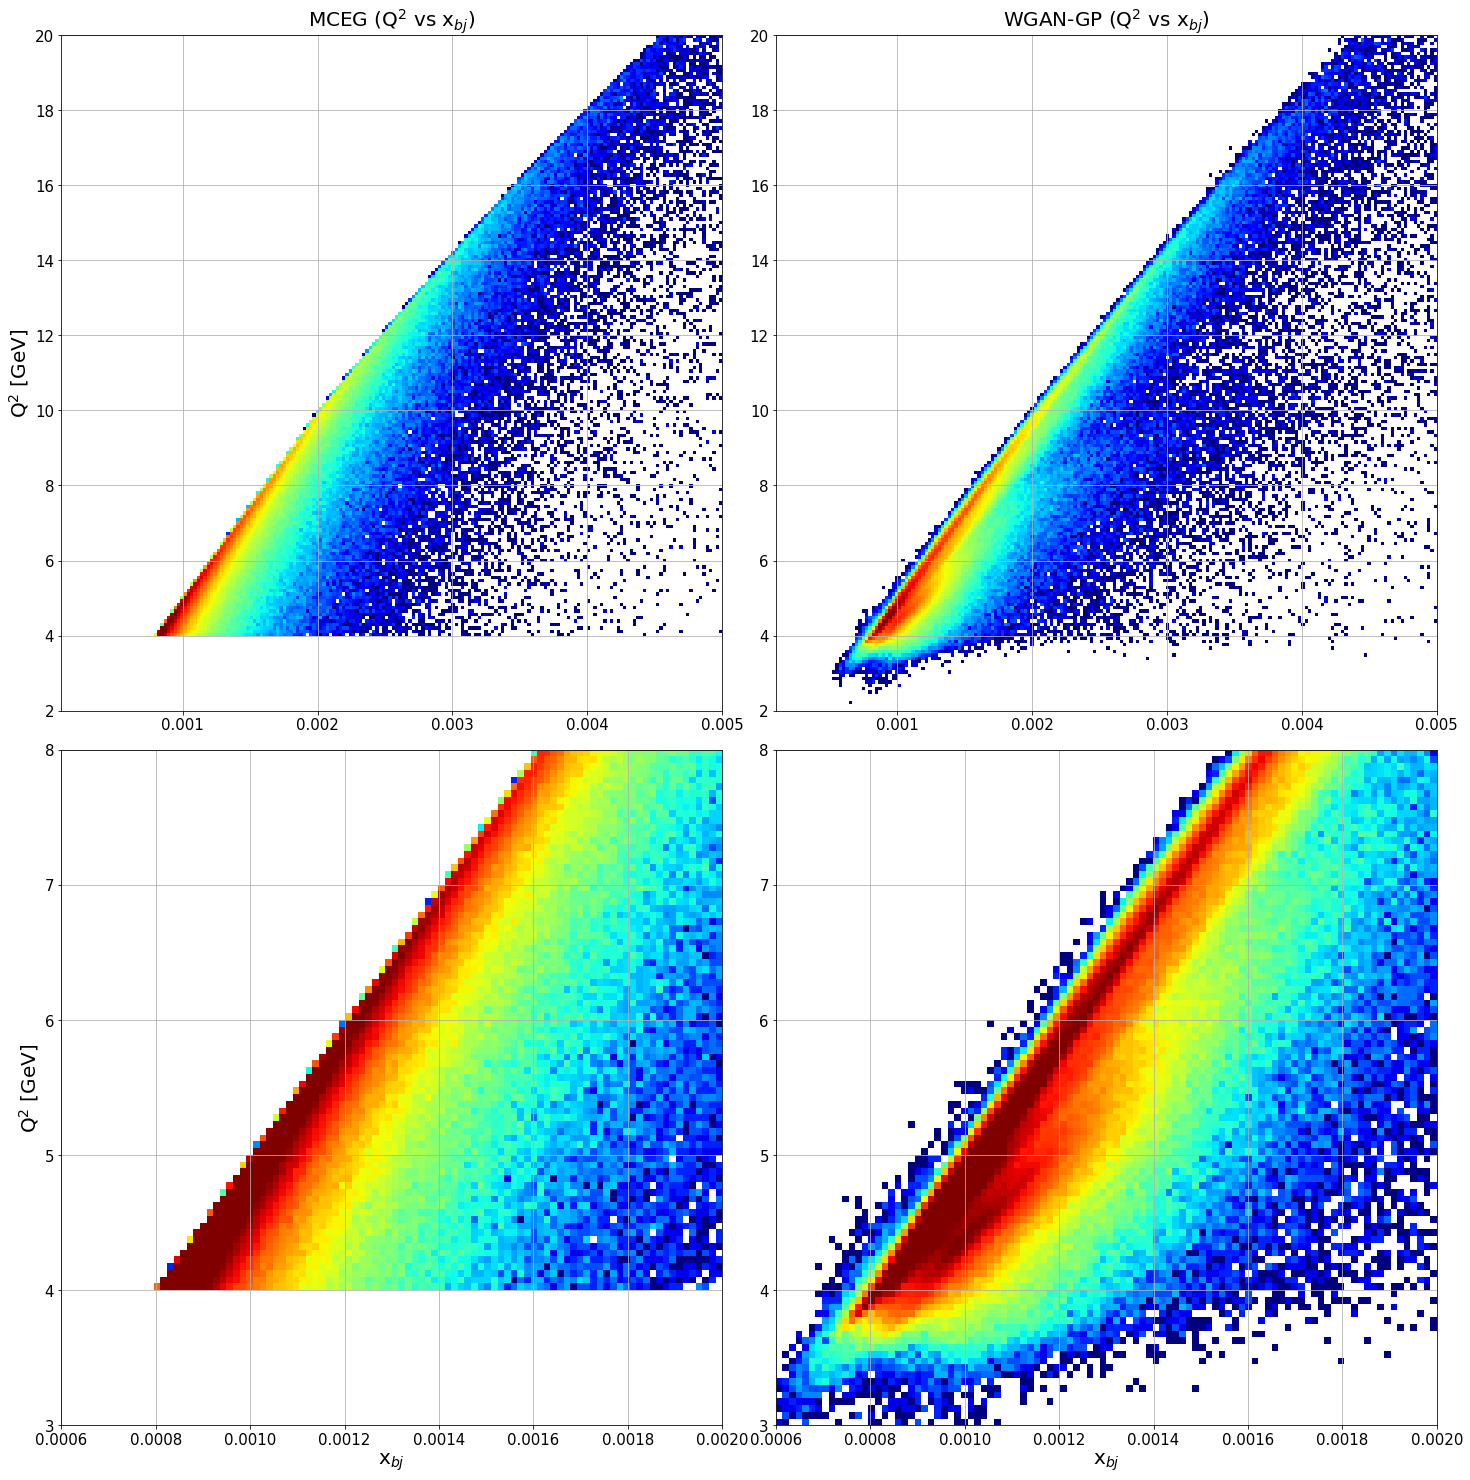

In [6]:
f, axs = plt.subplots(2,2, figsize=(20,20)); f.tight_layout()
vmin, vmax = 1, 10000
xyrange, bins = [[0.0001, 0.005],[2, 20]], 200#(500,500)
for ax, hh, lab in zip(axs[0,:].flatten(), [true, pred], ["MCEG", "WGAN-GP"]):
    ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    mpl_labels(ax, "", r"Q$^{2}$ [GeV]", lab, r"(Q$^{2}$ vs x$_{bj})$")
    # mpl_labels(ax, r"x$_{bj}$", r"Q$^{2}$ [GeV]", lab, r"(Q$^{2}$ vs x$_{bj}$)")

vmin, vmax = 1, 1000
xyrange, bins = [[0.0006, 0.002],[3, 8]], 100#(500,500)
for ax, hh, lab in zip(axs[1,:].flatten(), [true, pred], ["MCEG", "WGAN-GP"]):
    ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    # mpl_labels(ax, r"x$_{bj}$", r"Q$^{2}$ [GeV]", lab, r"(Q$^{2}$ vs x$_{bj}$)")
    ax.set_xlabel(r"x$_{bj}$")
    if lab == "MCEG": ax.set_ylabel(r"Q$^{2}$ [GeV]")
    ax.grid()

f.savefig(f"imgs/Q2xbj_comparison.png", bbox_inches='tight', dpi=300)

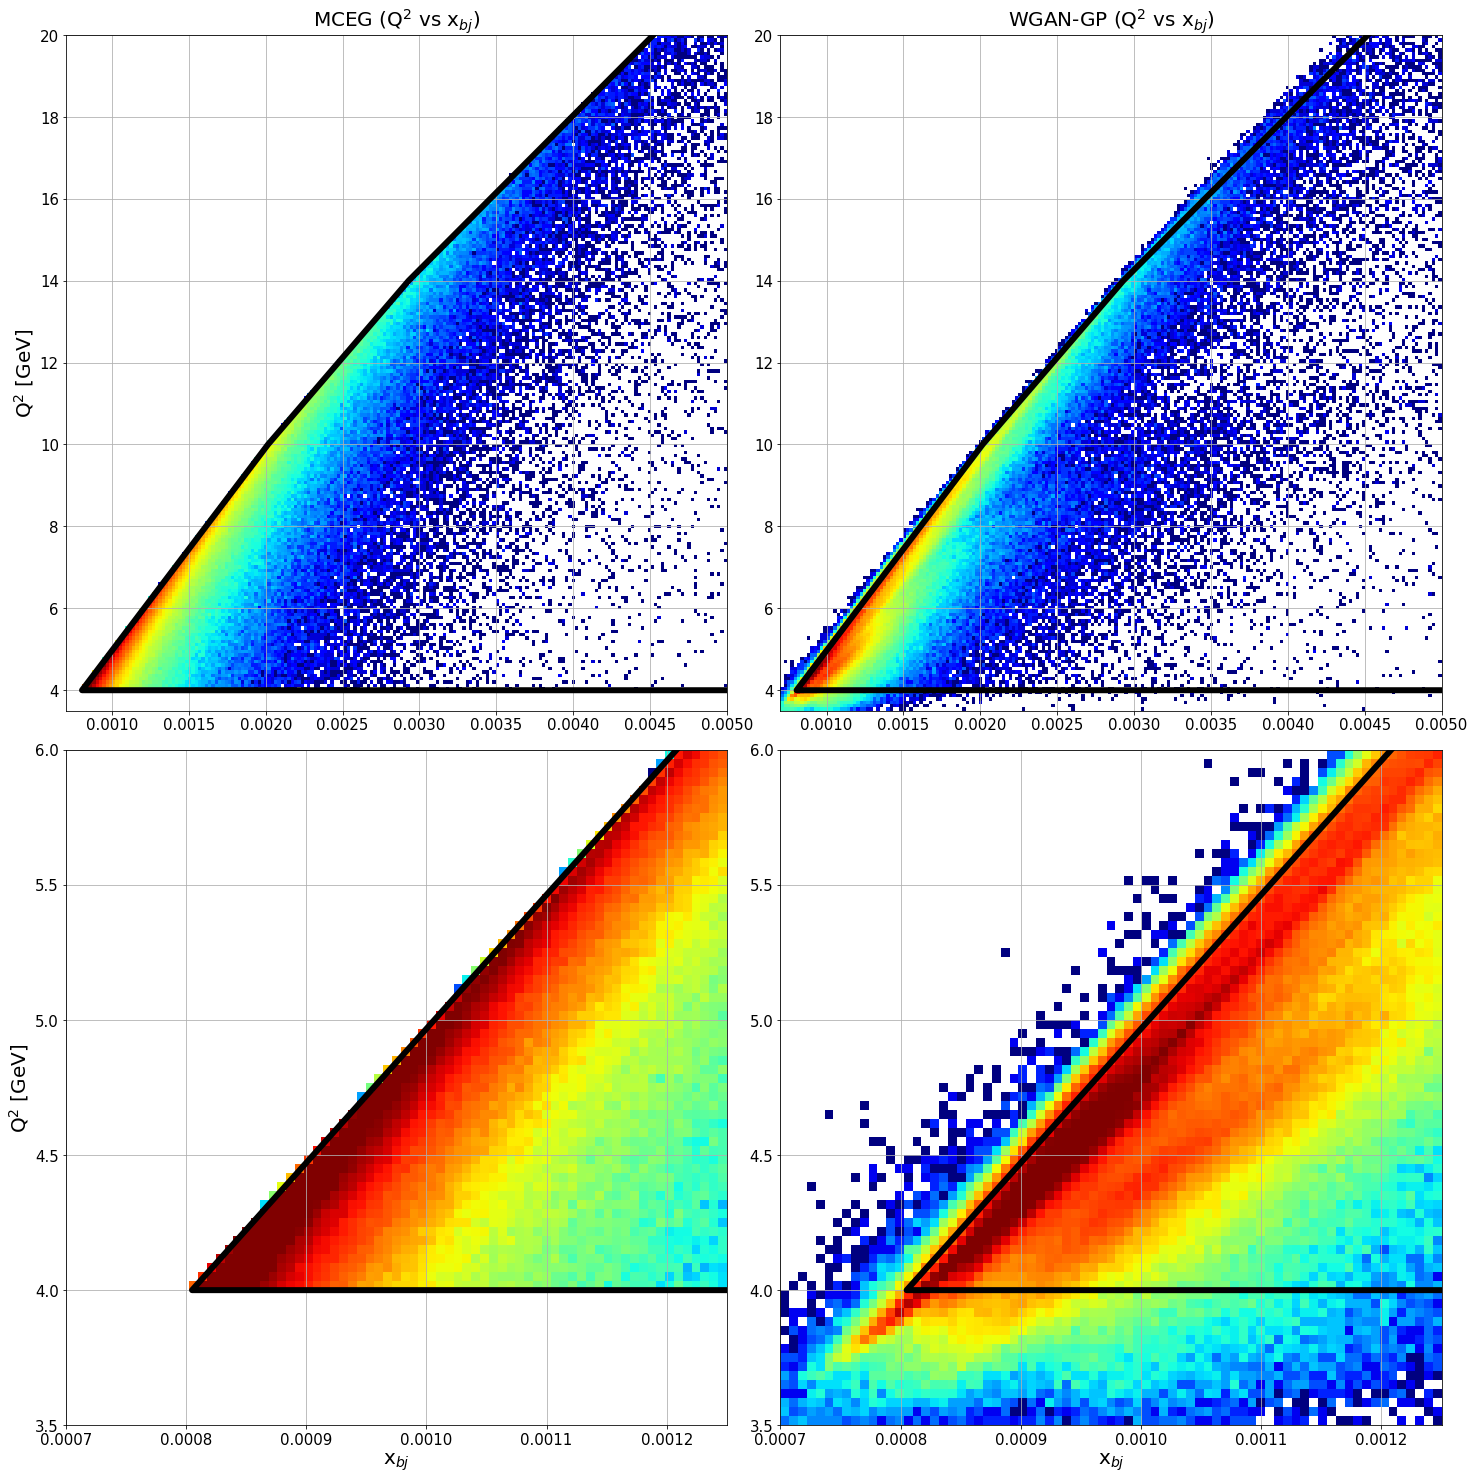

In [12]:
f, axs = plt.subplots(2,2, figsize=(20,20)); f.tight_layout()
vmin, vmax = 1, 10000

xyrange, bins = [[0.0007, 0.005],[3.5, 20]], 200#(500,500)
for ax, hh, lab in zip(axs[0,:].flatten(), [true, pred], ["MCEG", "WGAN-GP"]):
    ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    mpl_labels(ax, "", r"Q$^{2}$ [GeV]", lab, r"(Q$^{2}$ vs x$_{bj})$")
    ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=6)

vmin, vmax = 1, 1000
xyrange, bins = [[0.0007, 0.00125],[3.5, 6]], 75#(500,500)
for ax, hh, lab in zip(axs[1,:].flatten(), [true, pred], ["MCEG", "WGAN-GP"]):
    ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))
    ax.set_xlabel(r"x$_{bj}$")
    if lab == "MCEG": ax.set_ylabel(r"Q$^{2}$ [GeV]")
    ax.plot([0.005, 0.000805, 0.002015, 0.00293, 0.004522], [4, 4, 10, 14, 20], 'k', linewidth=6)
    ax.grid()

f.savefig(f"imgs/Q2xbj_with_lines.png", bbox_inches='tight', dpi=300)

In [8]:
# f, ax = plt.subplot(figsize=(20,10)); f.tight_layout()
# xyrange, bins = [[0.00075, 0.00125],[3.75, 6]], 200#(500,500)
# for ax, hh, lab in zip(axs.flatten(), [true, pred], ["TOPEG", "WGAN-GP"]):
# ax.hist2d(hh[:,3], hh[:,0], bins=bins, range=xyrange, cmap=mpl.cm.jet, norm=mpl.colors.LogNorm())
# mpl_labels(ax, r"x$_{bj}$", r"Q$^{2}$ [GeV]", lab, r"Q$^{2}$ vs x$_{bj}$")
# ax.plot([0.000805, 0.0012075], [4, 6], 'k:', linewidth=8)
# ax.plot([0.0008, 0.00125], [4, 4], 'k:', linewidth=8)
# # f.savefig(f"imgs/Q2xbj_comparison.png", bbox_inches='tight', dpi=300)

In [9]:
# import ROOT
# ROOT.gStyle.SetOptStat(0)
# ROOT.TGaxis.SetMaxDigits(2)
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins=500
# hq2xb_topeg = ROOT.TH2F("hq2xb_topeg", "TOPEG;x_{bj};Q^{2} [GeV]",   bins, 0.00075, 0.005, bins, 3.75, 20)
# hq2xb_gan = ROOT.TH2F("hq2xb_gan",     "wGAN-GP;x_{bj};Q^{2} [GeV]", bins, 0.00075, 0.005, bins, 3.75, 20)

# for h, d in zip([hq2xb_topeg, hq2xb_gan], [true, pred]):
#     for q2, xb in d[:,[0,3]]:
#         h.Fill(xb, q2)

# nc = 20
# for i, h in enumerate([hq2xb_topeg, hq2xb_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 2.5, nc)))
#     h.Draw("col")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2xb.png')

In [10]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins=300
# hq2xb_topeg = ROOT.TH2F("hq2xb_topeg", "TOPEG;x_{bj};Q^{2} [GeV]",   bins, 0.0008, 0.001, bins, 3.95, 4.75)
# hq2xb_gan = ROOT.TH2F("hq2xb_gan",     "wGAN-GP;x_{bj};Q^{2} [GeV]", bins, 0.0008, 0.001, bins, 3.95, 4.75)

# for h, d in zip([hq2xb_topeg, hq2xb_gan], [true, pred]):
#     for q2, xb in d[:,[0,3]]:
#         h.Fill(xb, q2)

# nc = 20
# for i, h in enumerate([hq2xb_topeg, hq2xb_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 1.5, nc)))
#     h.DrawCopy("colz")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2xb_zoomed.png')

In [11]:
# c1 = ROOT.TCanvas("c1", "c1", 2000, 1000); c1.Divide(2,1); c1.Draw()
# bins=300
# hq2t_topeg = ROOT.TH2F("hq2t_topeg","TOPEG;Q^{2};-t;count",bins,4,25,bins,0,1)
# hq2t_gan = ROOT.TH2F("hq2t_gan","GAN;Q^{2};-t;count",bins,4,25,bins,0,1)

# for h, d in zip([hq2t_topeg, hq2t_gan], [true, pred]):
#     for q2, t in d[:,[0,5]]:
#         h.Fill(q2, t)

# nc = 20
# for i, h in enumerate([hq2t_topeg, hq2t_gan]):
#     c1.cd(i+1).SetLogz()
#     c1.cd(i+1).SetGrid()
#     # h.SetContour(nc, np.append(0, np.logspace(0, 1.5, nc)))
#     h.Draw("col")
#     # h.SetContour(5)
#     # h.Draw("cont3 same")
#     # h.SetLineColor(ROOT.kRed)
#     # h.SetLineWidth(3)
# c1.Print('imgs/q2t.png')